# World Happiness (2015–2019): Data Cleaning Walkthrough

**Goal:** Create a single, analysis-ready dataset to study which factors affect cross-country happiness. This notebook documents each cleaning step for further regression.

**Inputs:** 2015.csv, 2016.csv, 2017.csv, 2018.csv, 2019.csv (from the World Happiness reports)

**Outputs:** a country-year dataset with consistent columns across years.


## Summary
1. **Schema harmonization:** Column names and coverage change over years (e.g., *Happiness Score* vs *Ladder score*). We map them to a standard set so you can pool years.
2. **Country name hygiene:** Trim, normalize Unicode, and reconcile common naming variants (e.g., *Czech Republic* → *Czechia*) to avoid duplicate keys.
3. **Minimal complete-case filtering:** For a clean first-pass regression, we drop rows missing the outcome or any core predictors.
4. **De-duplication:** Ensure only one row per (country, year) to avoid double-counting.
5. **Outlier filtering (IQR rule):** Mitigate undue leverage from extreme values without assuming normality.


## Setup
Import libararies and load data


In [33]:
import unicodedata
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Google Drive URLs converted to direct download format
google_drive_urls = {
    2015: 'https://drive.google.com/uc?export=download&id=1HDCKIV7uv06QkSfHlB17E3359LMsvzQN',
    2016: 'https://drive.google.com/uc?export=download&id=1ryI-wGXDvaO6yum-2ZItYauLc-BJSQFr', 
    2017: 'https://drive.google.com/uc?export=download&id=1vuybk2ipvlnxdNEUsVbyILRg8syHJgYp',
    2018: 'https://drive.google.com/uc?export=download&id=1gBLz6F8yLdg9klsMWmMDVHnM9l0sp-ew',
    2019: 'https://drive.google.com/uc?export=download&id=1rmnkgLDx86rzXN-5H22p0QlM1pzUrGmY'
}

# Note: Google Drive direct download URLs work seamlessly with pandas.read_csv()
# No special functions needed!

# Load the data from Google Drive
year_data = {}
print("Loading CSV files from Google Drive...")
print()

for year, url in google_drive_urls.items():
    print(f"Loading {year} data from Google Drive...")
    try:
        # Google Drive URLs work directly with pandas
        df = pd.read_csv(url)
        year_data[year] = df
        print(f"✓ Successfully loaded {year}: {df.shape}")
    except Exception as e:
        print(f"✗ Error loading {year}: {e}")
    print()

print(f"📊 Summary: Successfully loaded {len(year_data)} out of {len(google_drive_urls)} files")
year_data

Loading CSV files from Google Drive...

Loading 2015 data from Google Drive...
✓ Successfully loaded 2015: (158, 12)

Loading 2016 data from Google Drive...
✓ Successfully loaded 2015: (158, 12)

Loading 2016 data from Google Drive...
✓ Successfully loaded 2016: (157, 13)

Loading 2017 data from Google Drive...
✓ Successfully loaded 2016: (157, 13)

Loading 2017 data from Google Drive...
✓ Successfully loaded 2017: (155, 12)

Loading 2018 data from Google Drive...
✓ Successfully loaded 2017: (155, 12)

Loading 2018 data from Google Drive...
✓ Successfully loaded 2018: (156, 9)

Loading 2019 data from Google Drive...
✓ Successfully loaded 2018: (156, 9)

Loading 2019 data from Google Drive...
✓ Successfully loaded 2019: (156, 9)

📊 Summary: Successfully loaded 5 out of 5 files
✓ Successfully loaded 2019: (156, 9)

📊 Summary: Successfully loaded 5 out of 5 files


{2015:          Country                           Region  Happiness Rank  \
 0    Switzerland                   Western Europe               1   
 1        Iceland                   Western Europe               2   
 2        Denmark                   Western Europe               3   
 3         Norway                   Western Europe               4   
 4         Canada                    North America               5   
 ..           ...                              ...             ...   
 153       Rwanda               Sub-Saharan Africa             154   
 154        Benin               Sub-Saharan Africa             155   
 155        Syria  Middle East and Northern Africa             156   
 156      Burundi               Sub-Saharan Africa             157   
 157         Togo               Sub-Saharan Africa             158   
 
      Happiness Score  Standard Error  Economy (GDP per Capita)   Family  \
 0              7.587         0.03411                   1.39651  1.34951   


## Standardizing the schema
Different years use different column labels for the same concept. We normalize column names and keep a conservative, widely-available set for pooled regressions.


In [34]:
# Our target schema (columns we aim to keep)
standard_cols = [
    'country',
    'year',
    'happiness_score',
    'gdp_per_capita',
    'social_support',
    'healthy_life_expectancy',
    'freedom',
    'generosity',
    'corruption',
    'rank',
    'region',
]

# Alias dictionary maps lowercased source column names to our standardized names
alias_map = {
    # identifiers
    'country': 'country',
    'country or region': 'country',
    # core predictors
    'economy (gdp per capita)': 'gdp_per_capita',
    'gdp per capita': 'gdp_per_capita',
    'family': 'social_support',
    'social support': 'social_support',
    'health (life expectancy)': 'healthy_life_expectancy',
    'healthy life expectancy': 'healthy_life_expectancy',
    'freedom': 'freedom',
    'freedom to make life choices': 'freedom',
    'generosity': 'generosity',
    'trust (government corruption)': 'corruption',
    'perceptions of corruption': 'corruption',
    # outcome
    'happiness score': 'happiness_score',
    'score': 'happiness_score',
    'ladder score': 'happiness_score',
    # helpers
    'happiness rank': 'rank',
    'overall rank': 'rank',
    'region': 'region',
}

def normalize_colname(c):
    """Lowercase, strip, and collapse internal spaces in column names."""
    return " ".join(str(c).strip().lower().split())

def normalize_country(name):
    """Basic country hygiene: trim, Unicode normalize, and unify common variants."""
    if pd.isna(name):
        return name
    s = unicodedata.normalize('NFKC', str(name).strip())
    fixes = {
        'Congo (Brazzaville)': 'Congo',
        'Congo (Kinshasa)': 'Congo (Democratic Republic)',
        'Hong Kong S.A.R., China': 'Hong Kong',
        'Taiwan Province of China': 'Taiwan',
        'Russian Federation': 'Russia',
        'Macedonia': 'North Macedonia',
        'Bolivia (Plurinational State of)': 'Bolivia',
        'Viet Nam': 'Vietnam',
        'Iran, Islamic Republic of': 'Iran',
        'Czech Republic': 'Czechia',
        'Swaziland': 'Eswatini',
        'Gambia, The': 'Gambia',
        "Lao People's Democratic Republic": 'Laos',
    }
    return fixes.get(s, s)

def load_and_harmonize(df: pd.DataFrame, year: int) -> pd.DataFrame:
    """Take a DataFrame and map its columns into our standard schema.
    Adds missing columns as NaN to keep concatenation simple.
    """
    rename_dict = {}
    for c in df.columns:
        key = normalize_colname(c)
        if key in alias_map:
            rename_dict[c] = alias_map[key]
    df = df.rename(columns=rename_dict)

    # Ensure required columns exist (fill with NaN if absent in a given year)
    needed = ['country','happiness_score','gdp_per_capita','social_support',
              'healthy_life_expectancy','freedom','generosity','corruption',
              'rank','region']
    for col in needed:
        if col not in df.columns:
            df[col] = np.nan

    df = df[['country','happiness_score','gdp_per_capita','social_support',
             'healthy_life_expectancy','freedom','generosity','corruption',
             'rank','region']].copy()

    df['year'] = year
    df['country'] = df['country'].apply(normalize_country)
    return df


## Load and combine all years
We apply the harmonization to each year and then concatenate into one dataframe.


In [35]:
frames = []
for year, df in year_data.items():
    if df is not None:
        frames.append(load_and_harmonize(df, year))
        
if frames:
    raw = pd.concat(frames, ignore_index=True)
    print(f"Combined dataset shape: {raw.shape}")
    display(raw.head(3))
else:
    print("No data loaded successfully. Please check the URLs or network connection.")
    raw = pd.DataFrame()

Combined dataset shape: (782, 11)


,country,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom,generosity,corruption,rank,region,year
0,Switzerland,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,1.0,Western Europe,2015
1,Iceland,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,2.0,Western Europe,2015
2,Denmark,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,3.0,Western Europe,2015


## Sanity checks
We make sure the key identifiers/outcome are present before proceeding.


In [36]:
missing_country = raw['country'].isna().sum()
missing_score = raw['happiness_score'].isna().sum()
print('Missing country:', missing_country)
print('Missing happiness_score:', missing_score)

Missing country: 0
Missing happiness_score: 155


## Handle missing values (complete-case for core variables)
For a clear first-pass regression (OLS/LASSO), we drop rows missing the outcome or any of the core predictors. Imputation is a valid alternative if you prefer (e.g., median, MICE), but we avoid model-driven imputation here to keep estimates straightforward.


In [37]:
core_vars = [
    'happiness_score',
    'gdp_per_capita',
    'social_support',
    'healthy_life_expectancy',
    'freedom',
    'generosity',
    'corruption',
]

before_na = len(raw)
clean = raw.dropna(subset=['country','happiness_score'])
clean = clean.dropna(subset=core_vars)
after_na = len(clean)
print('Dropped due to NA in outcome/core vars:', before_na - after_na)
clean.shape

Dropped due to NA in outcome/core vars: 156


(626, 11)

## De-duplicate within (country, year)
Some vintages include slight duplicates. Keep only one row per country-year (prefer the row with a valid/earlier rank if available).


In [38]:
before_dup = len(clean)
clean = (clean
         .sort_values(['country','year','rank'], na_position='last')
         .drop_duplicates(subset=['country','year'], keep='first')
         .reset_index(drop=True))
after_dup = len(clean)
print('Dropped duplicates:', before_dup - after_dup)
clean.shape

Dropped duplicates: 0


(626, 11)

## Outlier filtering 
We mitigate the influence of extreme leverage points by filtering values lying outside `[Q1 - 1.5×IQR, Q3 + 1.5×IQR]` for the variables that will enter the regression.


In [39]:
def iqr_filter(df: pd.DataFrame, cols, k=1.5):
    mask = pd.Series(True, index=df.index)
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        if pd.isna(iqr) or iqr == 0:
            continue
        lower = q1 - k*iqr
        upper = q3 + k*iqr
        mask &= df[c].between(lower, upper, inclusive='both')
    return df.loc[mask].copy(), mask

before_out = len(clean)
# Using gentler threshold (3.0×IQR) to be more conservative with outlier removal
clean_iqr, keep_mask = iqr_filter(clean, ['happiness_score'] + core_vars, k=3.0)
after_out = len(clean_iqr)
print('Dropped as outliers (IQR with k=3.0):', before_out - after_out)
clean_iqr.shape

Dropped as outliers (IQR with k=3.0): 9


(617, 11)

## Save the final tidy dataset
We keep a consistent column order and cast `year` to integer for convenience.


In [40]:
ordered = clean_iqr[[
    'country','year','happiness_score','gdp_per_capita','social_support',
    'healthy_life_expectancy','freedom','generosity','corruption','rank','region'
]].copy()
ordered['year'] = ordered['year'].astype(int)

# Save to Downloads folder (Windows-compatible path)
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = Path.home() / 'Downloads' / f'happiness_clean_2015_2019_{timestamp}.csv'

try:
    ordered.to_csv(out_path, index=False)
    print(f"✓ Successfully saved cleaned dataset to: {out_path}")
    print(f"File size: {out_path.stat().st_size:,} bytes")
except Exception as e:
    print(f"Error saving file: {e}")
    print("Trying alternative location...")
    # Try current directory as backup
    out_path = Path('happiness_clean_2015_2019.csv')
    ordered.to_csv(out_path, index=False)
    print(f"✓ Saved to current directory: {out_path.absolute()}")

print(f"Dataset shape: {ordered.shape}")
print(f"Columns: {list(ordered.columns)}")

✓ Successfully saved cleaned dataset to: C:\Users\kenle\Downloads\happiness_clean_2015_2019_20251110_190504.csv
File size: 48,979 bytes
Dataset shape: (617, 11)
Columns: ['country', 'year', 'happiness_score', 'gdp_per_capita', 'social_support', 'healthy_life_expectancy', 'freedom', 'generosity', 'corruption', 'rank', 'region']


## Quick before/after checks
Basic counts and simple distributions to confirm the cleaning had the intended effect.


In [41]:
summary = {
    'rows_loaded_total': len(raw),
    'missing_country_initial': int(missing_country),
    'missing_score_initial': int(missing_score),
    'dropped_missing_core_vars': int(before_na - after_na),
    'dropped_duplicates_same_country_year': int(before_dup - after_dup),
    'dropped_outliers_iqr': int(before_out - after_out),
    'rows_final': len(ordered),
    'n_countries': ordered['country'].nunique(),
    'years_covered': sorted(ordered['year'].unique().tolist()),
}
summary

{'rows_loaded_total': 782,
 'missing_country_initial': 0,
 'missing_score_initial': 155,
 'dropped_missing_core_vars': 156,
 'dropped_duplicates_same_country_year': 0,
 'dropped_outliers_iqr': 9,
 'rows_final': 617,
 'n_countries': 167,
 'years_covered': [2015, 2016, 2018, 2019]}

### Distribution of happiness scores: raw vs. cleaned
One-figure histograms to visualize how filtering affects the tails.

> **Note:** We avoid seaborn and do not set styles or colors.


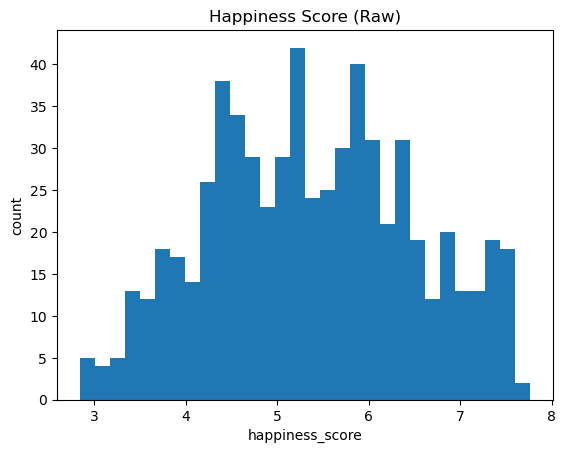

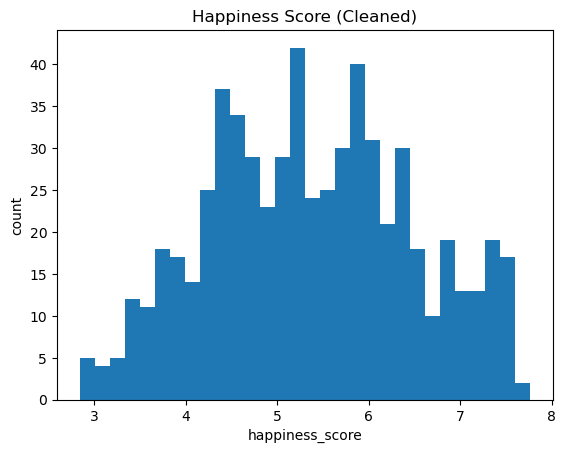

In [42]:
# Raw distribution
plt.figure()
raw['happiness_score'].plot(kind='hist', bins=30, title='Happiness Score (Raw)')
plt.xlabel('happiness_score')
plt.ylabel('count')
plt.show()

# Cleaned distribution
plt.figure()
ordered['happiness_score'].plot(kind='hist', bins=30, title='Happiness Score (Cleaned)')
plt.xlabel('happiness_score')
plt.ylabel('count')
plt.show()